# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

rcParams['font.size'] = 18

Populating the interactive namespace from numpy and matplotlib


/Users/bfulton/anaconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
def bin_same_night(rv):
    rv['jd_date'] = rv['time'].apply(lambda x: np.int(np.floor(x)))
    rv_mean = rv.groupby('jd_date',as_index=False).mean()
    rv_n = rv.groupby('jd_date',as_index=False).size()
    print(rv['tel'].iloc[0])
    print(len(rv_n))
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = linspace(t_start,t_stop,10000)

j
122
k
49
a
69


In [3]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params['tc1'] = radvel.Parameter(value=2456778 + 1)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1)
    params['per2'] = radvel.Parameter(value=75.765 + 0.1)
    params['tc2'] = radvel.Parameter(value=2456277.6)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1)
    params['dvdt'] = radvel.Parameter(value=0)
    params['curv'] = radvel.Parameter(value=0)
    mod = radvel.RVModel(params, time_base=time_base)
    return mod


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

Setting vary=False and linear=True on the gamma parameters will cause them to be solved for analytically following the technique described [here](http://cadence.caltech.edu/~bfulton/share/Marginalizing_the_likelihood.pdf) (Thanks Tim Brandt!). If you use this you will need to calculate the uncertainties on the gammas manually following that derivation.

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_hires_rj.params['jit_hires_rj'] = radvel.Parameter(value=np.log(1))

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_hires_rk.params['jit_hires_rk'] = radvel.Parameter(value=np.log(1))

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_apf.params['jit_apf'] = radvel.Parameter(value=np.log(1))

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = radvel.Parameter(value=log(2.6))
like.params['jit_hires_rj'] = radvel.Parameter(value=log(2.6))
like.params['jit_apf'] = radvel.Parameter(value=log(2.6))

# Do not vary dvdt or jitter (Fulton 2015)
like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['jit_hires_rk'].vary = False
like.params['jit_hires_rj'].vary = False
like.params['jit_apf'].vary = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1309.928781
Final loglikelihood = -767.134507
parameter                     value      vary
per1                        1198.64       True
tc1                         6775.56       True
secosw1                   -0.223475       True
sesinw1                    0.254041       True
logk1                       1.97241       True
per2                        75.7709       True
tc2                         6278.27       True
secosw2                  -0.0327104       True
sesinw2                    0.436144       True
logk2                      0.767926       True
dvdt                              0      False
curv                              0      False
gamma_hires_rj             0.227885      False
jit_hires_rj               0.955511      False
gamma_hires_rk              0.16619      False
jit_hires_rk               0.955511      False
gamma_apf                  0.998125      False
jit_apf                    0.955511      False

Priors
------
e1 constrained to be <

# Perform MCMC posterior exploration

In [6]:
df = radvel.mcmc(post, nrun=200)

20000/80000 (25.0%) steps complete; Running 11251.39 steps/s; Mean acceptance rate = 45.5%; Min Tz = 3208.2; Max G-R = 1.009      
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 9644.06 steps/s; Mean acceptance rate = 41.3%; Min Tz = 8122.9; Max G-R = 1.003      

MCMC: WARNING: chains did not pass 5 consecutive convergence tests. They may be marginally well=mixed.


In [7]:
df_synth = post.params.basis.to_synth(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 '.split()
df_synth[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.5,0.84
per1,1.197753e+03,1.198658e+03,1.199425e+03
tc1,2.456773e+06,2.456776e+06,2.456779e+06
e1,9.469894e-02,1.153884e-01,1.352977e-01
k1,6.985708e+00,7.178440e+00,7.358312e+00
per2,7.574789e+01,7.577102e+01,7.579247e+01
tc2,2.456277e+06,2.456278e+06,2.456279e+06
e2,1.024145e-01,1.851842e-01,2.484089e-01
k2,1.960770e+00,2.141220e+00,2.305000e+00


Compare with parameters from fulton et al. (2016)
---------

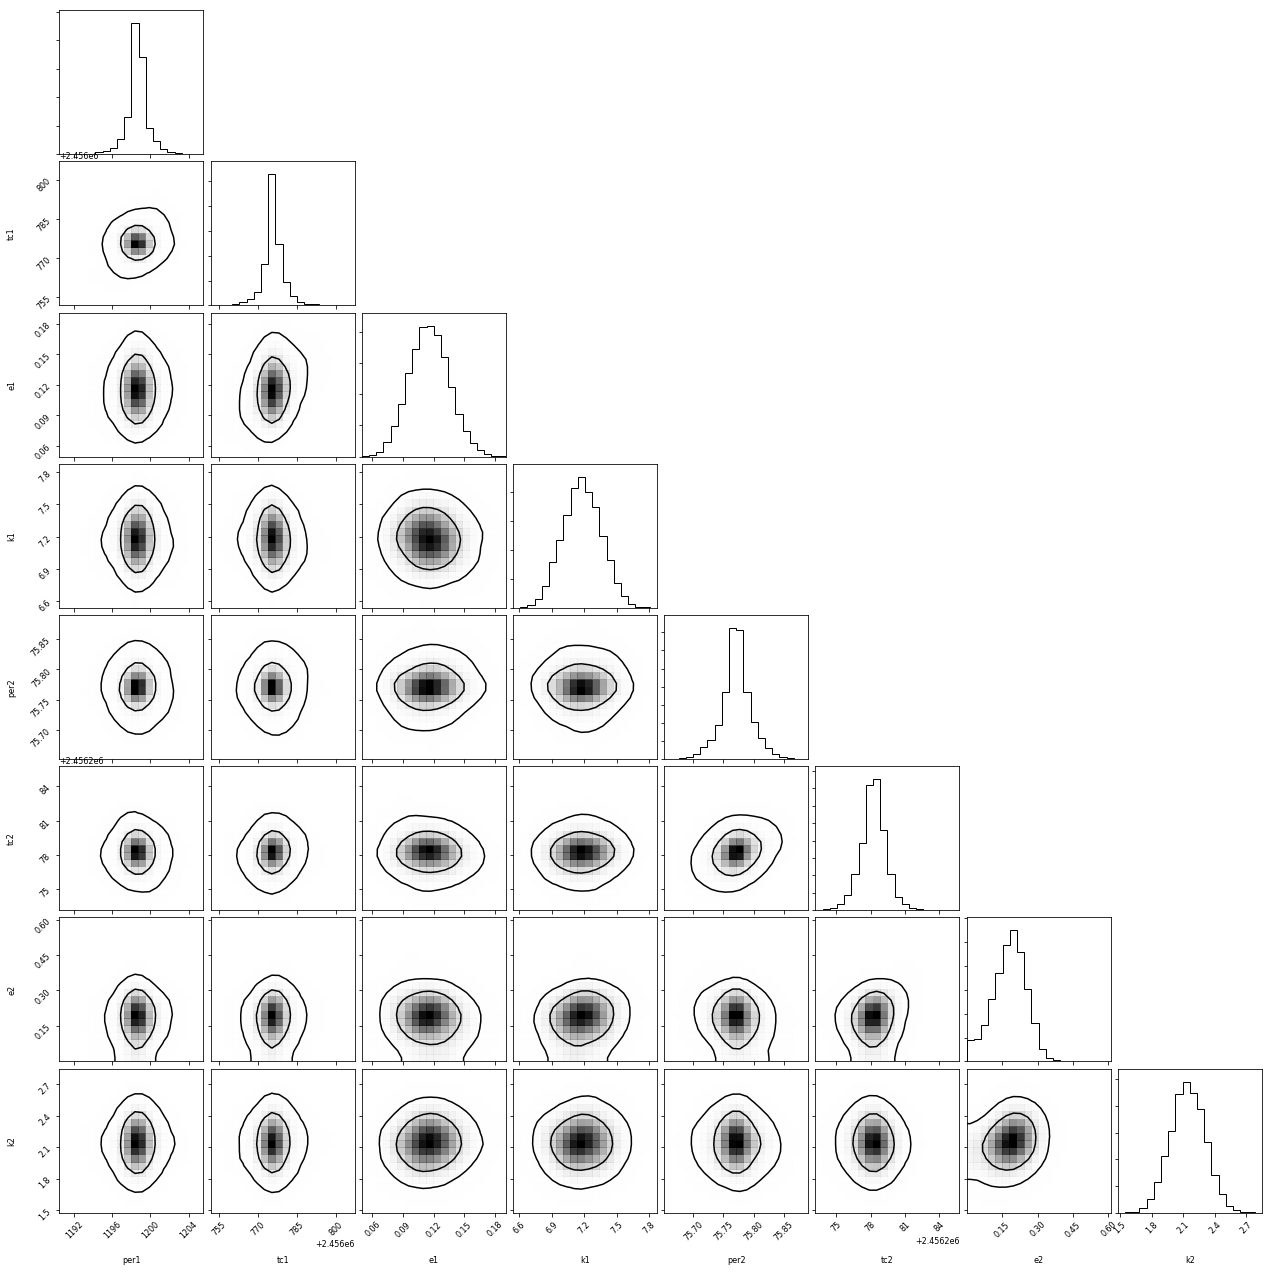

In [8]:
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2'.split()
rc('font',size=8)

fig = corner.corner(
    df_synth[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9d0b288208>])

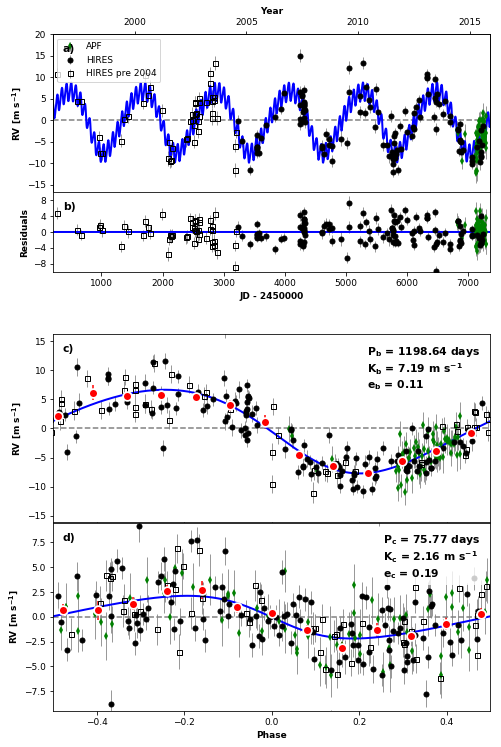

In [9]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()